In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import os.path

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.MNIST('../data',train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

testset = torchvision.datasets.MNIST('../data',train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

Processing...
Done!


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.linear1 = nn.Linear(196,392)
        self.linear2 = nn.Linear(392,784)
        
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        return x
    
Gnr = Generator()

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(784,392)
        self.linear2 = nn.Linear(392,196)
        self.linear3 = nn.Linear(196,1)
    
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x
    
Dsc = Discriminator()

In [5]:
criterion = nn.BCELoss()
Gnr_optimizer = optim.Adam(Gnr.parameters(), lr=0.001)
Dsc_optimizer = optim.Adam(Dsc.parameters(), lr=0.001)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Gnr.to(device)
Dsc.to(device)

cuda:0


Discriminator(
  (linear1): Linear(in_features=784, out_features=392, bias=True)
  (linear2): Linear(in_features=392, out_features=196, bias=True)
  (linear3): Linear(in_features=196, out_features=1, bias=True)
)

0


/home/hsue/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0 dsc finish
0 gnr finish
1
1 dsc finish
1 gnr finish
2
2 dsc finish
2 gnr finish
3
3 dsc finish
3 gnr finish
4
4 dsc finish
4 gnr finish
5
5 dsc finish
5 gnr finish
6
6 dsc finish
6 gnr finish
7
7 dsc finish
7 gnr finish
8
8 dsc finish
8 gnr finish
9
9 dsc finish
9 gnr finish


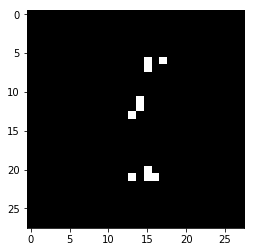

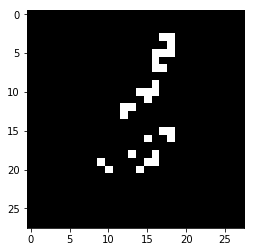

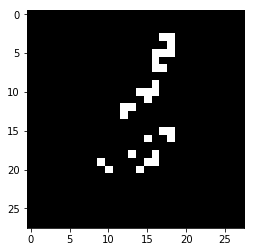

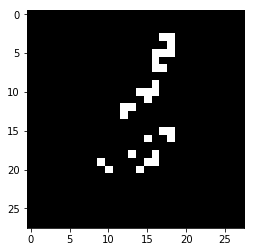

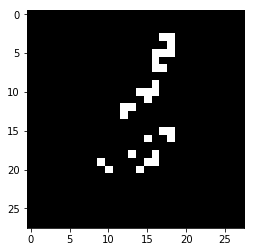

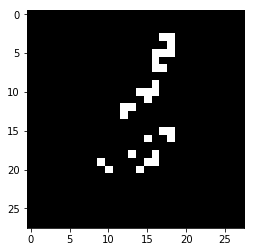

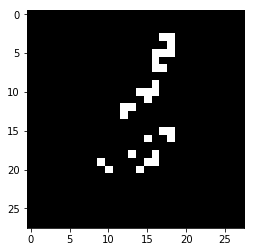

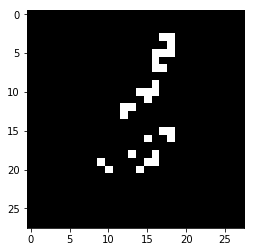

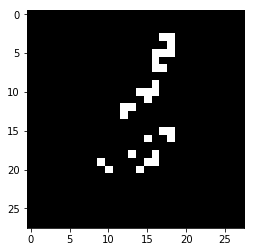

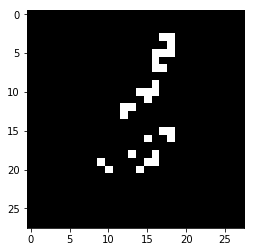

In [7]:
def preprocess(img):
    img = img[0]
    img = img.view(1,-1)
    return img

def noiseInput():
    return torch.randn(196)

if os.path.isfile('./gen1.pth'):
    Gnr.load_state_dict(torch.load('./gen1.pth'))
if os.path.isfile('./dsc1.pth'):
    Dsc.load_state_dict(torch.load('./dsc1.pth'))
        
for epoch in range(10):
    print(epoch)
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = preprocess(inputs).to(device)

        Dsc.zero_grad()
        dsc_real_result = Dsc(inputs)
        dsc_real_error = criterion(dsc_real_result, torch.ones(1).to(device))
        #dsc_real_error.backward()

        noise = noiseInput().to(device)
        gnr_fake = Gnr(noise)
        dsc_fake_result = Dsc(gnr_fake)
        dsc_fake_error = criterion(dsc_fake_result,torch.zeros(1).to(device))
        #dsc_fake_error.backward()
        
        loss = dsc_real_error + dsc_fake_error
        loss.backward()
        Dsc_optimizer.step()
    print(epoch,'dsc finish')
    
    g_loop = i
    for g in range(g_loop):
        Gnr.zero_grad()
        noise = noiseInput().to(device)
        gnr_fake = Gnr(noise)
        dsc_gnr_fake_result = Dsc(gnr_fake)
        gnr_error = criterion(dsc_gnr_fake_result, torch.ones(1).to(device))
        gnr_error.backward()
        Gnr_optimizer.step()
    print(epoch,'gnr finish')
    
    torch.save(Gnr.state_dict(),'./gen1.pth')
    torch.save(Dsc.state_dict(),'./dsc1.pth')
    
    plt.figure(epoch)
    noise = noiseInput().to(device)
    gnr_fake = Gnr(noise)
    fake = gnr_fake.cpu()
    fake_img = fake.reshape((28,28)).detach().numpy()
    plt.imshow(fake_img, cmap='gray')
